In [1]:
import argparse
import json
import logging
import pickle
import wandb
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pandas as pd
import os
import numpy as np
import copy

In [2]:
import matplotlib
matplotlib.rcParams.update(
    {
        "figure.dpi": 150,
        "font.size": 14,
        "figure.figsize": (7.5, 4.8)
    }
)
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

In [3]:
api = wandb.Api(timeout=200)

In [4]:
SMOOTH_WINDOW = 30


def smooth(to_smooth, window_size=SMOOTH_WINDOW):
    smoothed = []
    for idx, val in enumerate(to_smooth):
        if idx < window_size:
            smoothed.append(np.mean(to_smooth[: idx + 1]))
        else:
            smoothed.append(np.mean(to_smooth[idx - (SMOOTH_WINDOW - 1) : idx + 1]))

    return np.array(smoothed)

In [5]:
def load_groups(group_and_keys, relabel_dict, x_range, extra_filter):
    all_interp_data = []
    for group, x_key, y_key in group_and_keys:
        runs = api.runs(
            path="resl-mixppo/stabilized-rl",
            filters={
                "$and": [
                    {"group": group},
                    {"$not": {"tags": "exclude-from-paper"}},
                    extra_filter,
                ]
            },
        )
        print(f"Got {len(runs)} runs for group {group}")
        x_vals = np.linspace(x_range[0], x_range[1], 1000)
        for r in tqdm(runs):
            # h = r.history(samples=2000, keys=[x_key, y_key])
            h = pd.DataFrame(r.scan_history(keys=[x_key, y_key]))
            try:
                interp_y = np.interp(x_vals, h[x_key], smooth(h[y_key], 30))
            except KeyError:
                print("Could not get keys in run", r)
            else:
                env = r.config['env']
                all_interp_data.append(
                    pd.DataFrame.from_dict(
                        {
                            relabel_dict.get(x_key, x_key): x_vals,
                            relabel_dict.get(y_key, y_key): interp_y,
                            relabel_dict.get("group", "group"): relabel_dict.get(
                                group, group
                            ),
                            "run": str(r),
                            relabel_dict.get("env", "env"): relabel_dict.get(
                                env, env
                            ),
                        }
                    )
                )
    return pd.concat(all_interp_data, ignore_index=True)

In [9]:
relabels = {
    "xppo-512-5": "xPPO",
    "baseline_ppo": "PPO-clip",
    "xppo10m-512-5": "xPPO",
    "basline_ppo_10m": "PPO-clip",
    "xppo_single_step_4096": "xPPO $|D_{h}|=32000$",
    "basline_stbl_ppo": "PPO-clip 4096",
    'xppo_single_step_large_historic': "xPPO $|D_{h}|=128000$",
    "xppo_single_step_no_historic": "xPPO $|D_{h}|=4096$",
    "global_step": "Total Environment Steps",
    "rollout/ep_rew_mean": "Average Episode Reward",
    "group": "Algorithm",
    'env': "Environment",
    'rollout/SuccessRate':'Average Success Rate',
    'train/std': "Action Distribution STD",
    "<SawyerPushEnvV2 instance>":"push",
    "<SawyerWindowCloseEnvV2 instance>":"window-close",
    "<SawyerDoorEnvV2 instance>":"door-open",
    "<SawyerReachEnvV2 instance>":"reach",
    "<SawyerButtonPressTopdownEnvV2 instance>":"button-press-topdown",
    "<SawyerWindowOpenEnvV2 instance>":"window-open",
    "<SawyerDrawerOpenEnvV2 instance>":"drawer-open",
    "<SawyerPegInsertionSideEnvV2 instance>":"peg-insert-side",
    "<SawyerDrawerCloseEnvV2 instance>":"drawer-close",
}
envs = ["<SawyerPushEnvV2 instance>",
"<SawyerWindowCloseEnvV2 instance>",
"<SawyerDoorEnvV2 instance>",
"<SawyerReachEnvV2 instance>",
"<SawyerButtonPressTopdownEnvV2 instance>",
"<SawyerPickPlaceEnvV2 instance>",
"<SawyerWindowOpenEnvV2 instance>",
"<SawyerDrawerOpenEnvV2 instance>",
"<SawyerPegInsertionSideEnvV2 instance>",
"<SawyerDrawerCloseEnvV2 instance>",]

## Pick-Place

In [32]:

env = "PickPlace-V2"
config_env = "<SawyerPickPlaceEnvV2 instance>"
total_steps=20e6
group_and_keys = [
    ("xppo_single_step_4096", "global_step",  "rollout/SuccessRate"),
    ("xppo_single_step_large_historic", "global_step", "rollout/SuccessRate"),
    ('xppo_single_step_no_historic', "global_step", "rollout/SuccessRate"),
    ("basline_stbl_ppo", "global_step", "rollout/SuccessRate"),
]
tag_filter = {"tags": {"$in": ["stbl_ppo_pick-place_baseline"]}}

# Don't add baseline_stbl_ppo as a group, that mixes the batch_size 50k v/s default size
group_filter = {"group": {"$in": ["xppo_single_step_4096", "xppo_single_step_large_historic", 'xppo_single_step_no_historic']}} # to not exclude not yet tagged runs
env_filter = {"config.env":config_env}


extra_filter = {"$or": [tag_filter, {"$and": [group_filter,env_filter]}]}
all_data = load_groups(
    group_and_keys,
    relabels,
    (0, total_steps),
    extra_filter
)

Got 27 runs for group xppo_single_step_4096


100%|██████████| 27/27 [00:12<00:00,  2.20it/s]


Got 8 runs for group xppo_single_step_large_historic


100%|██████████| 8/8 [00:02<00:00,  3.49it/s]


Got 10 runs for group xppo_single_step_no_historic


100%|██████████| 10/10 [00:02<00:00,  3.52it/s]


Got 3 runs for group basline_stbl_ppo


100%|██████████| 3/3 [00:06<00:00,  2.12s/it]


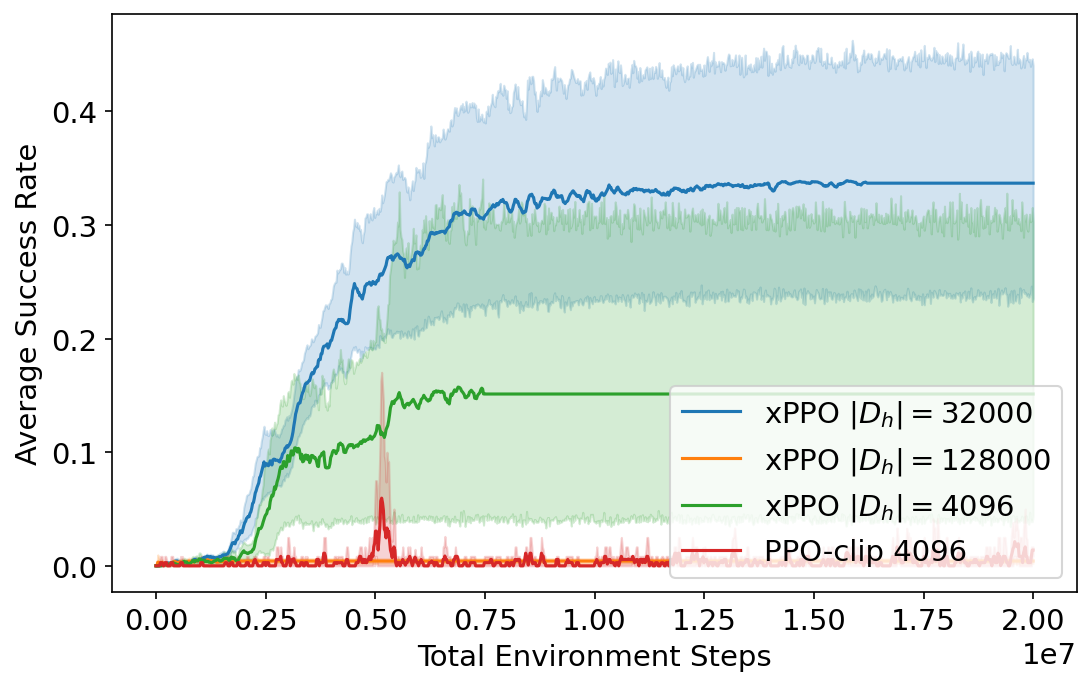

In [33]:
sns.lineplot(
    data=all_data,
    x="Total Environment Steps",
    y="Average Success Rate",
    hue="Algorithm",
    ci=95,
    # style="Environment",
    # palette="viridis",
)
plt.legend(loc="lower right")
# plt.legend(loc='upper left', bbox_to_anchor=(0.90, 1),
#           ncol=1, fancybox=True, shadow=True, fontsize=13)
plt.tight_layout()
plt.savefig(f"historical_buffer_sweep_{env}.pdf")


## Window Open

In [34]:

env = 'WindowOpen'
config_env = "<SawyerWindowOpenEnvV2 instance>"
total_steps = 3e6
group_and_keys = [
    ("xppo_single_step_4096", "global_step",  "rollout/SuccessRate"),
    ("xppo_single_step_large_historic", "global_step", "rollout/SuccessRate"),
    ('xppo_single_step_no_historic', "global_step", "rollout/SuccessRate"),
    ("basline_stbl_ppo", "global_step", "rollout/SuccessRate"),
]
tag_filter = {"tags": {"$in": ["stbl_ppo_pick-place_baseline"]}}

# Don't add baseline_stbl_ppo as a group, that mixes the batch_size 50k v/s default size
group_filter = {"group": {"$in": ["xppo_single_step_4096", "xppo_single_step_large_historic", 'xppo_single_step_no_historic']}} # to not exclude not yet tagged runs
env_filter = {"config.env":config_env}


extra_filter = {"$or": [tag_filter, {"$and": [group_filter,env_filter]}]}
all_data = load_groups(
    group_and_keys,
    relabels,
    (0, total_steps),
    extra_filter
)

Got 31 runs for group xppo_single_step_4096


100%|██████████| 31/31 [00:12<00:00,  2.42it/s]


Got 7 runs for group xppo_single_step_large_historic


100%|██████████| 7/7 [00:01<00:00,  3.81it/s]


Got 9 runs for group xppo_single_step_no_historic


100%|██████████| 9/9 [00:02<00:00,  3.46it/s]


Got 3 runs for group basline_stbl_ppo


100%|██████████| 3/3 [00:06<00:00,  2.09s/it]


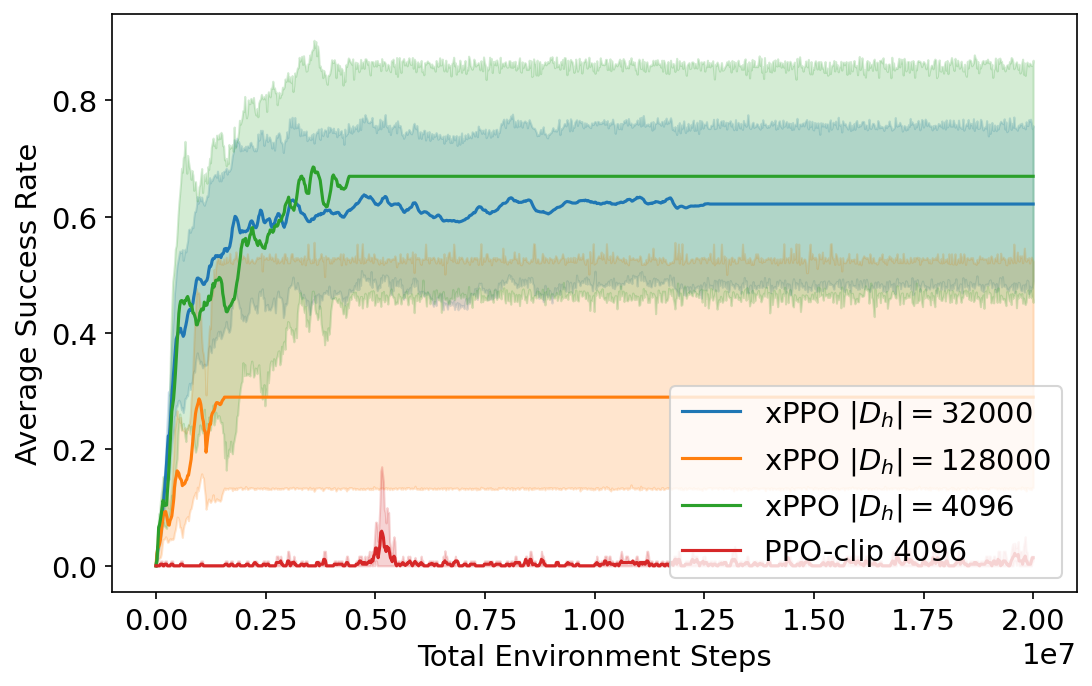

In [35]:
sns.lineplot(
    data=all_data,
    x="Total Environment Steps",
    y="Average Success Rate",
    hue="Algorithm",
    ci=95,
    # style="Environment",
    # palette="viridis",
)
plt.legend(loc="lower right")
# plt.legend(loc='upper left', bbox_to_anchor=(0.90, 1),
#           ncol=1, fancybox=True, shadow=True, fontsize=13)
plt.tight_layout()
plt.savefig(f"historical_buffer_sweep_{env}.pdf")


## Reach

In [10]:

env = 'Reach'
config_env = "<SawyerReachEnvV2 instance>"
total_steps = 3e6
group_and_keys = [
    ("xppo_single_step_4096", "global_step",  "rollout/SuccessRate"),
    ("xppo_single_step_large_historic", "global_step", "rollout/SuccessRate"),
    ('xppo_single_step_no_historic', "global_step", "rollout/SuccessRate"),
    ("basline_stbl_ppo", "global_step", "rollout/SuccessRate"),
]
tag_filter = {"tags": {"$in": ["stbl_ppo_pick-place_baseline"]}}

# Don't add baseline_stbl_ppo as a group, that mixes the batch_size 50k v/s default size
group_filter = {"group": {"$in": ["xppo_single_step_4096", "xppo_single_step_large_historic", 'xppo_single_step_no_historic']}} # to not exclude not yet tagged runs
env_filter = {"config.env":config_env}


extra_filter = {"$or": [tag_filter, {"$and": [group_filter,env_filter]}]}
all_data = load_groups(
    group_and_keys,
    relabels,
    (0, total_steps),
    extra_filter
)

Got 26 runs for group xppo_single_step_4096


100%|██████████| 26/26 [00:10<00:00,  2.55it/s]


Got 8 runs for group xppo_single_step_large_historic


100%|██████████| 8/8 [00:02<00:00,  3.86it/s]


Got 11 runs for group xppo_single_step_no_historic


100%|██████████| 11/11 [00:03<00:00,  3.13it/s]


Got 3 runs for group basline_stbl_ppo


100%|██████████| 3/3 [00:06<00:00,  2.08s/it]


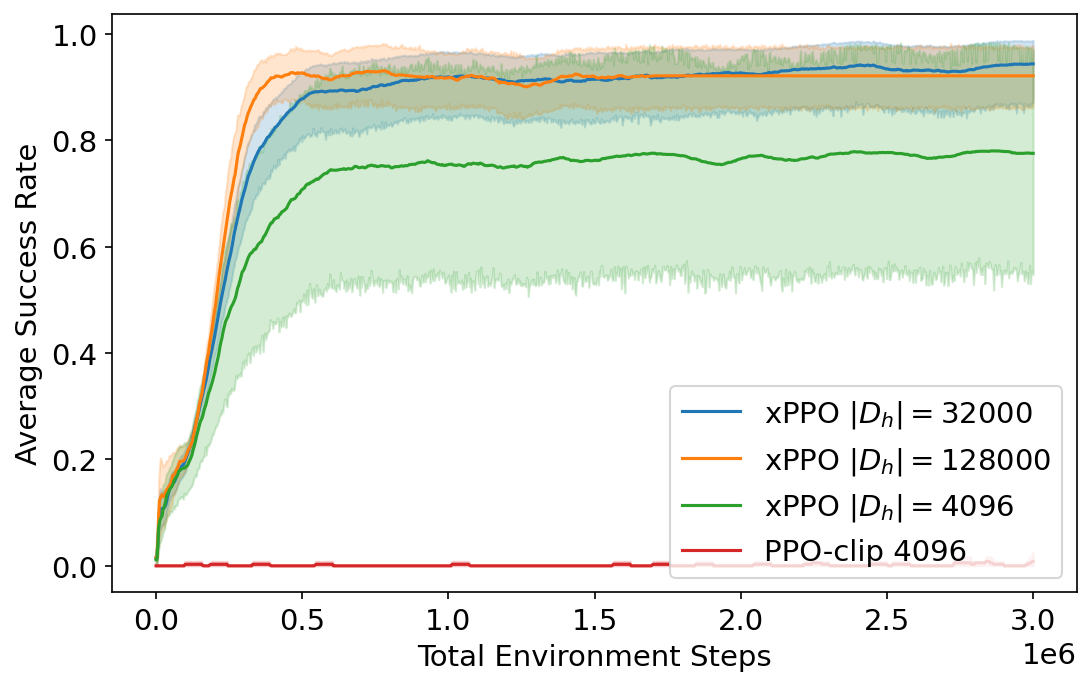

In [12]:
sns.lineplot(
    data=all_data,
    x="Total Environment Steps",
    y="Average Success Rate",
    hue="Algorithm",
    ci=95,
    # style="Environment",
    # palette="viridis",
)
plt.legend(loc="lower right")
# plt.legend(loc='upper left', bbox_to_anchor=(0.90, 1),
#           ncol=1, fancybox=True, shadow=True, fontsize=13)
plt.tight_layout()
plt.savefig(f"historical_buffer_sweep_{env}.pdf")
